# NYC Subway Forecasting with Machine Learning
## Notebook by Jack Carlisle, PhD and Nick Haubrich, PhD
![Subway photo](https://upload.wikimedia.org/wikipedia/commons/f/f6/BwyWalk0505_StationLincolnCenter.jpg)
Photo by <a href="//commons.wikimedia.org/w/index.php?title=User:Aspersions&amp;action=edit&amp;redlink=1" class="new" title="User:Aspersions (page does not exist)">Aspersions</a> - <span class="int-own-work" lang="en">Own work</span>, Public Domain, <a href="https://commons.wikimedia.org/w/index.php?curid=174483">Link</a>





**With over 400 stations and up to millions of daily riders, the New York Subway is one of the largest and busiest services of its kind. The Metropolitan Transit Authority (MTA) periodically releases data on its usage as part of its [Open Data Program](https://new.mta.info/open-data). In this notebook we will use machine learning techniques to model ridership (usage) of the subway system.**

**[Our dataset](https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-July-2020/wujg-7c2s/about_data) consists of hourly ridership at each subway station from February 2022 to October 2024.  We'll visualize this data, construct a training pipeline in PyTorch, train three models, and evaluat them.**

## Table Of Contents
## 1. Visualization
## 2. Preprocessing the Data
## 3. Building and Training Models
## 4. Performance Analysis and Conclusions



## Visualization
First, we'll visualize part of the data.

Let's get our package dependencies out of the way before we begin.

In [ ]:
!pip install geoplot
!pip install geopandas
!pip install contextily
!mkdir subwayimages
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mapclassify as mc
from shapely.geometry import Point
import os
import imageio
from IPython.display import Image
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import datetime
import copy

device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 926.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 34.1 MB/s eta 0:00:00
cuda


Here we specify the day and call the API. We'll do March 30, 2023, but DAY can be changed to any date after 2022-02-01.


In [ ]:
#Download data
DAY='2023-03-30'
STARTTIME=DAY+'T00:00:00.000'
ENDTIME=DAY+'T23:59:59.999'
!curl 'https://data.ny.gov/resource/wujg-7c2s.json?$where=transit_timestamp%20between%20%27'"$STARTTIME"'%27%20and%20%27'"$ENDTIME"'%27&$limit=1000000' -o stationData.json

sourcedata = pd.read_json('stationData.json')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.0M    0 27.0M    0     0  9065k      0 --:--:--  0:00:03 --:--:-- 9066k


Now, with some formatting adjustments, we can plot the ridership at each station for every hour using Geoplot.

<ipython-input-3-21e4a86822c2>:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(images_path,filename)))


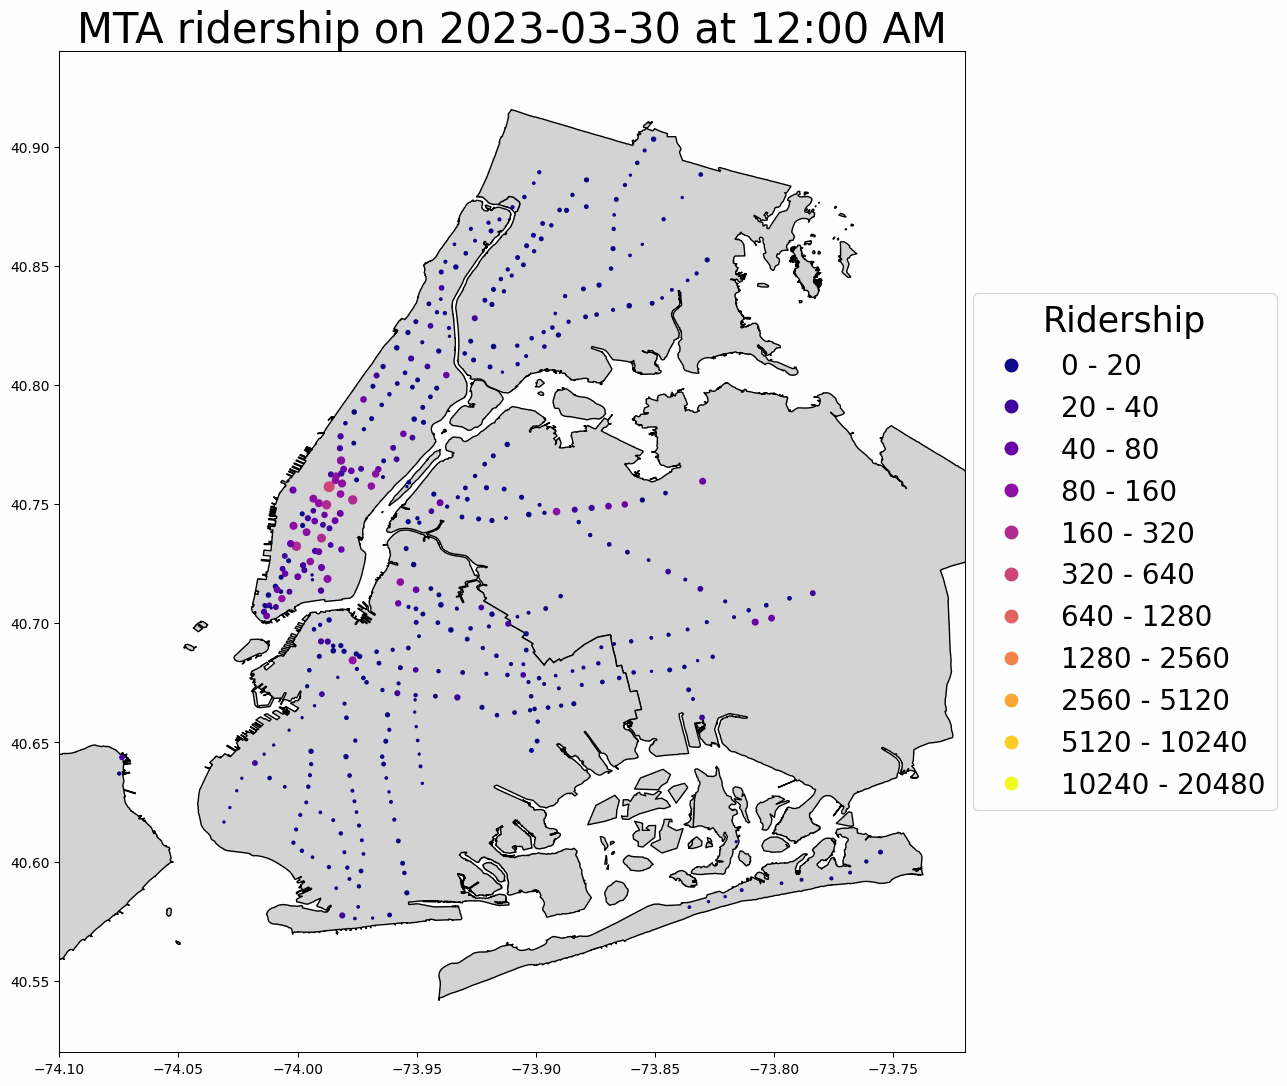

In [ ]:
#time and data formatting
from_military_time = {}
from_military_time[0] = '12:00:00 AM'
from_military_time[12] = '12:00:00 PM'

for t in range(1,12):
  from_military_time[t] = str(t).zfill(2) + ':00:00 AM'
  from_military_time[t+12] = str(t).zfill(2) + ':00:00 PM'

dictionary = {}
for i, row in sourcedata.iterrows():
  if row['station_complex_id'] not in dictionary.keys():
    dictionary[row['station_complex_id']] = [0]*24

for i, row in sourcedata.iterrows():
  dictionary[row['station_complex_id']][int(row['transit_timestamp'].split("T")[1].split(":")[0]) -1] += row['ridership']

data = sourcedata[['station_complex_id','longitude','latitude']].copy()
data.drop_duplicates(subset= 'station_complex_id', keep = 'first', inplace = True, ignore_index = True)
for t in range(24):
  data[from_military_time[t] + ' ridership'] = 0

for station in dictionary.keys():
  for t in range(24):
    data.loc[data['station_complex_id'] == station, from_military_time[t] + ' ridership'] = dictionary[station][t]
for t in range(24):
  data[from_military_time[t] + ' ridershipscaled'] = 2*np.sqrt(1 + data[from_military_time[t] + ' ridership'] )

#Begin plotting
for t in range(24):
  df_geo = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
  boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
  axis = boroughs.plot(color = 'lightgray', edgecolor = 'black')
  axis.set_ylim(40.52,40.94)
  axis.set_xlim((-74.1, -73.72))
  bins = [20,40,80,160,320,640,1280, 2560, 5120, 10240, 20480]
  df_geo.plot( from_military_time[t]+' ridership',
              markersize = from_military_time[t] + ' ridershipscaled',
               scheme = 'userdefined',
               legend = True, k = 10,
               ax = axis, cmap = 'plasma',
               legend_kwds = {'title': 'Ridership',
                              'title_fontsize':25,
                              'loc' : 'center right',
                              'bbox_to_anchor' : (1.36,0.5),
                              'fontsize' : 20,
                              'fancybox' : True,
                              'labels':['0 - 20', '20 - 40', '40 - 80', '80 - 160', '160 - 320', '320 - 640', '640 - 1280', '1280 - 2560', '2560 - 5120', '5120 - 10240', '10240 - 20480']},
               classification_kwds={'bins': bins, 'lowest':0})
  plt.title('MTA ridership on {} at '.format(DAY) + from_military_time[t][:5]+from_military_time[t][-3:], fontsize = 30)

  fig = matplotlib.pyplot.gcf()
  fig.set_size_inches(13,13)
  plt.savefig(f'subwayimages/{t:002}', bbox_inches = 'tight')
  plt.close()

images = []
images_path = 'subwayimages'

for filename in sorted(os.listdir(images_path)):
  if filename.endswith('.png'):
    images.append(imageio.imread(os.path.join(images_path,filename)))

imageio.mimsave('MTAanimation.gif', images, fps = 3, loop = 0)
Image("MTAanimation.gif")

## Preprocessing The Data

Some processing of the whole dataset is needed to get it into a PyTorch-friendly format.

For that, we have a preprocessing step, which:
1. Downloads the dataset (~30 minutes)
2. Standardizes the time into 24h format
3. Sorts the file into rows chronologically
4. Creates a pandas dataframe with the total ridership and ridership for each station per hour.

This process takes approximately an hour, so for convenience we'll download the a copy of the final processed data file, plus the two preprocessing scripts for reference. To remake the data, uncomment and run the last two lines.

In [ ]:
! wget "drive.google.com/uc?export=download&id=1tDDipJyiPjbfSGVEkaotvN8FHFfuflVx" -O "MTA_Oct08_sorted_skimmed.csv"
! wget "drive.google.com/uc?export=download&id=19tT6rV9N0giCBUMcIaBA_MGUJNNFtE2P" -O "MTA_Oct08_sorted_skimmed_station.csv"

! gdown --id 1n4yLNwmeokDqbrnBUvQuU8isthpyDdBM --output get_mta_data.sh
! gdown --id 1g-AKyc-0xSM2xazUp9wngSHdlJWNAj9T --output skim.py

#! chmod +x get_mta_data.sh
#! ./get_mta_data.sh

--2024-11-15 18:22:33--  http://drive.google.com/uc?export=download&id=1tDDipJyiPjbfSGVEkaotvN8FHFfuflVx
Resolving drive.google.com (drive.google.com)... 172.253.117.113, 172.253.117.100, 172.253.117.138, ...
Connecting to drive.google.com (drive.google.com)|172.253.117.113|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1tDDipJyiPjbfSGVEkaotvN8FHFfuflVx [following]
--2024-11-15 18:22:33--  https://drive.google.com/uc?export=download&id=1tDDipJyiPjbfSGVEkaotvN8FHFfuflVx
Connecting to drive.google.com (drive.google.com)|172.253.117.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1tDDipJyiPjbfSGVEkaotvN8FHFfuflVx&export=download [following]
--2024-11-15 18:22:33--  https://drive.usercontent.google.com/download?id=1tDDipJyiPjbfSGVEkaotvN8FHFfuflVx&export=download
Resolving drive.usercontent.google.com (drive.userco

Let's take a look at the processed data. We have a dataframe with a timestamp, the total ridership, and then extra "time" features created by the processing. For hour, dayOfWeek, and month, these encode the unit via

$
\mathrm{timeX} = \cos(2\pi\frac{\mathrm{time}}{P})
$ and $
\mathrm{timeY} = \cos(2\pi\frac{\mathrm{time}}{P}),
$

where time is specified in hours, days, or months; and $P$ is the epoch length (i.e. 24 for hours, 7 for dayOfWeek, and 12 for months). This encodes the hour into the position of the clock hand, which avoids the large jumps when changing epochs.

The preprocessor also adds a flag for US holidays determined from the [holidays](https://pypi.org/project/holidays/) library.

In [ ]:
subwaydata = pd.read_csv('MTA_Oct08_sorted_skimmed_station.csv')
subwaydata.head()

,Unnamed: 0,timestamp,ridership,hourX,hourY,dayOfWeekX,dayOfWeekY,monthX,monthY,isHoliday,...,station_91,station_93,station_94,station_95,station_96,station_97,station_98,station_99,station_TRAM1,station_TRAM2
0,0,2022-02-01 00:00:00,11334,1.000000,0.000000,0.62349,0.781831,0.5,0.866025,0,...,17,11,11,6,11,13,18,9,6,1
1,1,2022-02-01 01:00:00,3786,0.965926,0.258819,0.62349,0.781831,0.5,0.866025,0,...,6,1,5,2,4,12,8,2,3,1
2,2,2022-02-01 02:00:00,2732,0.866025,0.500000,0.62349,0.781831,0.5,0.866025,0,...,6,4,4,5,4,8,3,1,0,0
3,3,2022-02-01 03:00:00,3503,0.707107,0.707107,0.62349,0.781831,0.5,0.866025,0,...,3,9,9,6,7,10,2,0,0,0
4,4,2022-02-01 04:00:00,12289,0.500000,0.866025,0.62349,0.781831,0.5,0.866025,0,...,11,14,21,24,15,39,14,2,0,0


When plotted, strong trends in the ridership emerge: the daily cycle, the morning and evening rush hours, and the reduced activity on weekends. These strong trends are a sign of underlying structure that a model should be able to imitate.

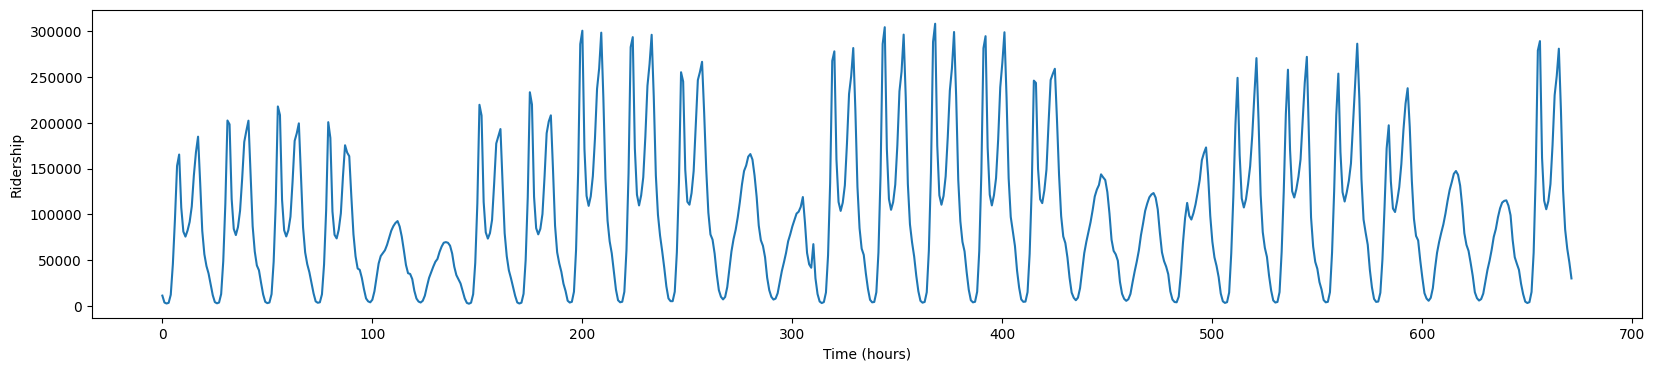

In [ ]:
plt.figure(figsize = (20,4))
plt.plot( subwaydata["ridership"][0:24*28])
plt.xlabel("Time (hours)")
plt.ylabel("Ridership")
plt.show()

To keep values in a reasonable range for our training, we normalize the ridership variable by shifting and scaling it to be centered at 0 and a standard deviation of 1.

In [ ]:
selected_subway_data = subwaydata[['ridership','hourX','hourY','dayOfWeekX','dayOfWeekY','monthX','monthY','isHoliday']].values
input_shape = selected_subway_data.shape[1]

normalization_idxs = [0]
normalization_mean_and_stds = []
for idx in normalization_idxs: #normalize the ridership, saving the mean and std to un-normalize the final predictions
  normalization_mean_and_stds.append((selected_subway_data[:,idx].mean(),selected_subway_data[:,idx].std()))
  selected_subway_data[:,idx] = (selected_subway_data[:,idx]-selected_subway_data[:,idx].mean())/selected_subway_data[:,idx].std()

## Building and training our models

The fundamental idea of time-series prediction is to use several previous values to predict the next one. This converts it into a regression problem, which is a staple of machine learning. We will fit several models to an initial "training" portion of the data and see how well they extrapolate to the "test" portion. Each model will take the previous few timesteps of data and return a prediction for the next.



The following code block defines the core training setup.
 - **timeseries_dataset**: Separates the time series into an array where each row consists of the last few values plus the target next value.
 - **CustomDataset**: Dataset for Pytorch data loader
 - **training_loop**: This iterates over the dataset for some number of epochs and fits the model to the data.
 - **train_model_on_dataset**: This puts all the blocks together by constructing the dataset and feeding it to the training loop.

The training setup uses 70% of the data to train and 10% for validation, witholding the last 20% for testing. Mean squared error (MSE) is used as the loss function to be minimized, and weights are updated with the Adam optimizer. After training over the specified epochs, the best model (determined by the validation loss) is returned.

In [ ]:
def timeseries_dataset(data,lookback):
    X = []
    y = []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback,:])
        y.append(data[i+lookback,0])
    X, y = torch.Tensor(np.array(X)).float(), torch.Tensor(np.array(y)).float().unsqueeze(1)
    return X , y

class CustomDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i], self.y[i]


def training_loop(n_epochs, optimizer, model, loss_fn, train_loader,val_loader=None,tag=""):
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[i*100 for i in range(1,n_epochs//100+1)],gamma=0.1)
    model.train()
    trainLosses = []
    valLosses = []
    minValLoss = None
    bestModel = None
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        loss_val = 0.0

        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train += loss.item()
        if epoch ==1 or epoch % 10 == 0:
            if val_loader:
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        outputs = model(inputs)
                        loss_val+=loss_fn(outputs, labels).item()
                print('{} Epoch {}, Training loss {}, Validation loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader),loss_val/len(val_loader)))
                trainLosses.append((loss_train/len(train_loader)))
                valLosses.append((loss_val/len(val_loader)))

                if minValLoss==None or minValLoss>loss_val/len(val_loader):
                    minValLoss = loss_val/len(val_loader)
                    bestModel = copy.deepcopy(model).to(device)
            else:
              print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))
    model = bestModel
    model.eval()
    plt.title(tag)
    plt.plot(trainLosses,label="training loss")
    plt.plot(valLosses,label="validation loss")
    plt.xlabel("10's of epochs")
    plt.yscale('log')
    plt.ylabel("loss")
    plt.legend()
    plt.show()
    plt.clf()


def train_model_on_dataset(dataset,model,lookback,epochs,batch_size=32,learning_rate=.001,tag=""):
  print(tag)
  model = model.to(device)
  X , y  = timeseries_dataset(dataset,lookback)
  X=X.to(device)
  y=y.to(device)
  input_shape = X.shape[2]

  split_val_index = int(len(X)*0.7)
  split_test_index = int(len(X)*0.8)

  X_train = X[:split_val_index]
  X_val = X[split_val_index:split_test_index]
  X_test = X[split_test_index:]

  y_train = y[:split_val_index]
  y_val = y[split_val_index:split_test_index]
  y_test = y[split_test_index:]

  data_train = CustomDataset(X_train,y_train)
  data_val = CustomDataset(X_val,y_val)
  data_test = CustomDataset(X_test,y_test)

  train_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(data_val, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(data_test, batch_size = batch_size, shuffle = True)

  learning_rate = learning_rate
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

  training_loop(
      n_epochs = epochs,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = train_loader,
      val_loader = val_loader,
      tag = tag

  )
  return model,X_test,y_test

Now we can define a few models to try.
 - **LinearModel**: Good old linear regression
 - **Net**: A dense or fully-connected neural network with one hidden layer and ReLU activation
 - **LSTM**: Long Short-Term Memory network, a recurrent neural network with memory that can persist over many timesteps


In [ ]:
class LinearModel(nn.Module):
  def __init__(self,input_size,output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, output_size)

  def forward(self, x):
    return self.fc1(x.reshape([x.shape[0],-1]))

class Net(nn.Module):
  def __init__(self,input_size,output_size,hidden_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = x.reshape([x.shape[0],-1])
    out = F.relu(self.fc1(x))
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

class LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_stacked_layers,dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True,dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out

First, we train our linear model.

Linear_Model
2024-11-15 16:07:26.458998 Epoch 1, Training loss 0.3966238871362578, Validation loss 0.3396991081025502
2024-11-15 16:07:33.049528 Epoch 10, Training loss 0.16333115920278657, Validation loss 0.17679654908915088
2024-11-15 16:07:40.161004 Epoch 20, Training loss 0.10622915963108293, Validation loss 0.1191951038494502
2024-11-15 16:07:47.343236 Epoch 30, Training loss 0.08436371300391372, Validation loss 0.09682459976166895
2024-11-15 16:07:54.682537 Epoch 40, Training loss 0.0753723686695857, Validation loss 0.08787405615902111
2024-11-15 16:08:01.599464 Epoch 50, Training loss 0.07063652511591315, Validation loss 0.08259114475078778
2024-11-15 16:08:09.004958 Epoch 60, Training loss 0.0675762216332724, Validation loss 0.07955385262325201
2024-11-15 16:08:15.813854 Epoch 70, Training loss 0.06555381247595157, Validation loss 0.07725621435842285
2024-11-15 16:08:23.739403 Epoch 80, Training loss 0.06392699812489713, Validation loss 0.07519230562938403
2024-11-15 16:08:30.9

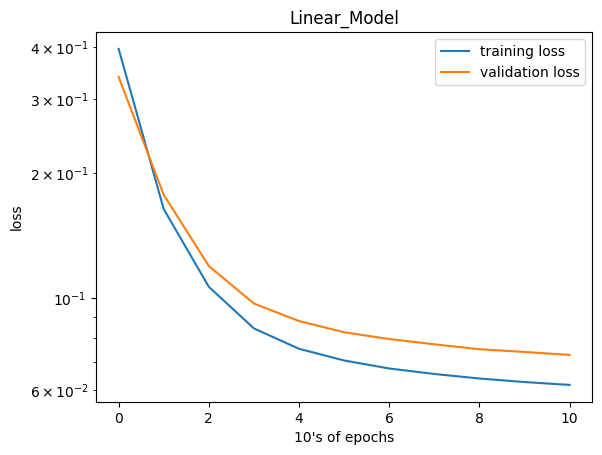

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = 100
batch_size=32
learning_rate=.001
lookback = 12


model_Linear_subway = LinearModel(input_shape*lookback,1)
model_NN_subway,X_test_subway,y_test_subway = train_model_on_dataset(selected_subway_data,model_Linear_subway,lookback,batch_size=batch_size,epochs=epochs,learning_rate=learning_rate,tag="Linear_Model")


Next, we train our neural network model.

NN
2024-11-15 16:08:39.881093 Epoch 1, Training loss 0.06572327832372425, Validation loss 0.03315980125167598
2024-11-15 16:08:48.604112 Epoch 10, Training loss 0.004347272233221016, Validation loss 0.008143828842112769
2024-11-15 16:08:57.699548 Epoch 20, Training loss 0.003055108799972734, Validation loss 0.0063421058688593445
2024-11-15 16:09:07.211670 Epoch 30, Training loss 0.0025948651681504706, Validation loss 0.004824439129052199
2024-11-15 16:09:16.774518 Epoch 40, Training loss 0.002245574000092413, Validation loss 0.004817490909274106
2024-11-15 16:09:25.975927 Epoch 50, Training loss 0.0021006637130984254, Validation loss 0.004168649023870797
2024-11-15 16:09:35.109634 Epoch 60, Training loss 0.001949443334463889, Validation loss 0.003784237943800192
2024-11-15 16:09:44.609264 Epoch 70, Training loss 0.0019017702400608721, Validation loss 0.0036243307053379407
2024-11-15 16:09:54.061384 Epoch 80, Training loss 0.0018412746379011604, Validation loss 0.0038812405729589804
202

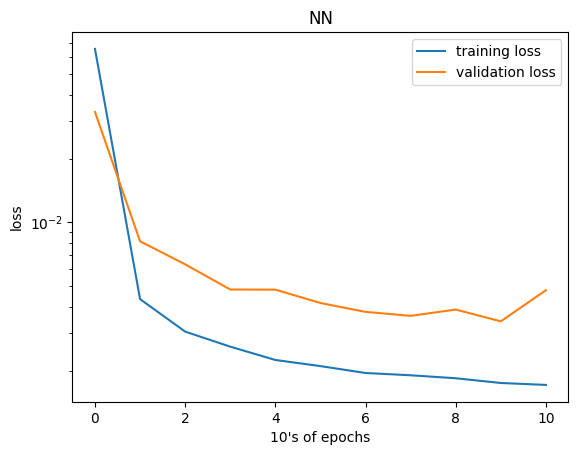

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = 100
batch_size=32
learning_rate=.001
lookback = 12

model_NN_subway = Net(input_shape*lookback,output_size=1,hidden_size=128)
model_NN_subway,X_test_subway,y_test_subway = train_model_on_dataset(selected_subway_data,model_NN_subway,lookback,batch_size=batch_size,epochs=epochs,learning_rate=learning_rate,tag="NN")

Finally, we train our LSTM model.

LSTM
2024-11-15 16:10:14.298994 Epoch 1, Training loss 0.1588781926955904, Validation loss 0.05468469498398369
2024-11-15 16:10:26.193636 Epoch 10, Training loss 0.011000961027474465, Validation loss 0.018138949644483933
2024-11-15 16:10:39.196672 Epoch 20, Training loss 0.007529534351439699, Validation loss 0.014517477821966964
2024-11-15 16:10:52.383674 Epoch 30, Training loss 0.0058861581839661165, Validation loss 0.011149305563215932
2024-11-15 16:11:05.621660 Epoch 40, Training loss 0.00474120073515736, Validation loss 0.008432663218054462
2024-11-15 16:11:18.785160 Epoch 50, Training loss 0.0038756093869410425, Validation loss 0.007038145448872182
2024-11-15 16:11:31.849578 Epoch 60, Training loss 0.003335026291712987, Validation loss 0.006962112481195531
2024-11-15 16:11:45.177719 Epoch 70, Training loss 0.0029723443519898167, Validation loss 0.005391545620848973
2024-11-15 16:11:58.468270 Epoch 80, Training loss 0.002776180810560226, Validation loss 0.005708662247642466
2024-11

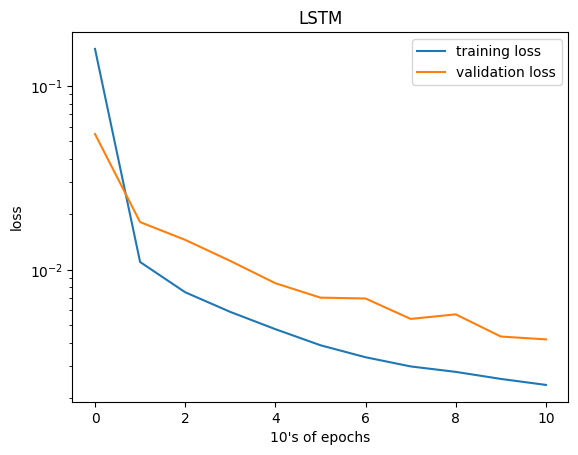

<Figure size 640x480 with 0 Axes>

In [ ]:
epochs = 100
batch_size=32
learning_rate=.001
lookback = 12

model_LSTM_subway = LSTM(input_size=input_shape,hidden_size=128,output_size=1,num_stacked_layers=1)
model_LSTM_subway,X_test_subway,y_test_subway = train_model_on_dataset(selected_subway_data,model_LSTM_subway,lookback,batch_size=batch_size,epochs=epochs,learning_rate=learning_rate,tag="LSTM")

## Performance Analysis and Conclusions

While the mean squared error is helpful for training, other metrics give a better sense of how the models perform. Here we examine the models' abilities to extrapolate into the future. Our models only predict a single step into the future, but we'd ideally like to go further. We can do that by autoregression, where we feed the model's prediction back into itself to predict yet another value.

**compute_extrapolation** predicts "n_future" hours' ridership through autoregression, starting at hour "n_start". We can plot the predictions of each model and compare them to the actual values for our test dataset. Let's do that for a week of data. The forecast window can be adjusted with **maxForecast** and **start_hour**.

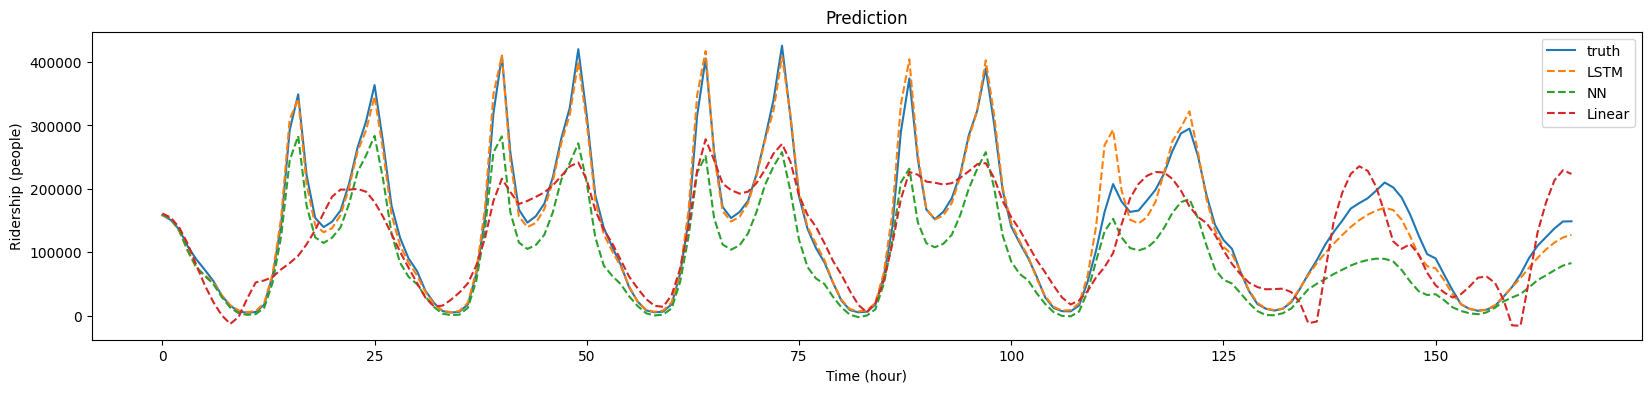

<Figure size 640x480 with 0 Axes>

In [ ]:
#Make a series of predictions by feeding the series back into the model
def compute_extrapolation(model,X,y,lookback,n_start,n_future):
  with torch.no_grad():
      iterative_preds = torch.zeros((n_future,X.shape[1],1)).to(device)
      iterative_preds[0]=X[n_start,:,0:1].detach().clone()

      det_features = X[n_start:n_start+n_future,:,1:]#get all features except ridership
      for k in range(n_future-1):
        input = torch.concat([iterative_preds[k],det_features[k]],dim=1).unsqueeze(0)
        prediction = model( input)
        iterative_preds[k+1]=torch.concat([iterative_preds[k][1:],prediction])

      return iterative_preds[1:,-1,0].detach(),y[n_start:n_start+n_future-1].squeeze().detach()

maxForecast=24*7 #hours
start_hour=100

pred_LSTM, truth = compute_extrapolation(model_LSTM_subway,X_test_subway,y_test_subway,lookback,start_hour,maxForecast)
pred_NN, truth = compute_extrapolation(model_NN_subway,X_test_subway,y_test_subway,lookback,start_hour,maxForecast)
pred_Linear, truth = compute_extrapolation(model_Linear_subway,X_test_subway,y_test_subway,lookback,start_hour,maxForecast)

shift, scale = normalization_mean_and_stds[0]

plt.figure(figsize = (20,4))

plt.plot(truth.cpu()*scale+shift,label='truth')
plt.plot(pred_LSTM.cpu()*scale+shift,label='LSTM',linestyle='dashed')
plt.plot(pred_NN.cpu()*scale+shift,label='NN',linestyle='dashed')
plt.plot(pred_Linear.cpu()*scale+shift,label='Linear',linestyle='dashed')

plt.title("Prediction")
plt.legend()
plt.xlabel("Time (hour)")
plt.ylabel("Ridership (people)")
plt.savefig("Model_example_predictions.png")
plt.show()
plt.clf()

For a comparison over the whole dataset, we can evaluate the root mean squared error (RMSE) for all predictions X hours ahead with **forecast**, then plot this for each hour. This becomes computationally intensive, as many evaluations of the model are needed for each prediction. But for lengths below a week the time is manageable.

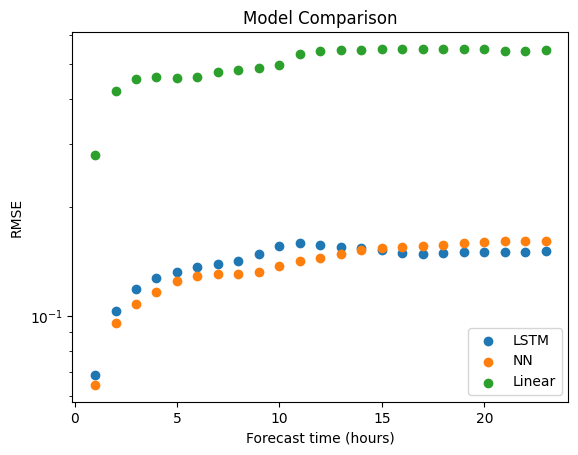

<Figure size 640x480 with 0 Axes>

In [ ]:
def forecast(model,X_test,y_test,lookback,n_future):
    #return RMSE for i-th hour predictions
    squaredErrors = torch.zeros(n_future-1).to(device)
    for i in range(X_test.shape[0]-n_future):
        extrapolated_pred, extrapolated_truth = compute_extrapolation(model,X_test,y_test,lookback,i,n_future)
        squaredErrors += (extrapolated_truth-extrapolated_pred)**2
    return (squaredErrors/(X_test.shape[0]-n_future)).sqrt()


maxForecast = 24
LSTM_RMSEs =forecast(model_LSTM_subway,X_test_subway,y_test_subway,12,maxForecast)
NN_RMSEs =forecast(model_NN_subway,X_test_subway,y_test_subway,12,maxForecast)
Linear_RMSEs =forecast(model_Linear_subway,X_test_subway,y_test_subway,12,maxForecast)

for RMSEs,label in [(LSTM_RMSEs,"LSTM"),(NN_RMSEs,"NN"),(Linear_RMSEs,"Linear")]:
  plt.scatter(range(1,len(RMSEs)+1),RMSEs.cpu(),label=label)
  plt.xlabel("Forecast time (hours)")
  plt.ylabel("RMSE")
plt.title("Model Comparison")
plt.yscale("log")
plt.legend()
plt.savefig("Model_comparison.png")
plt.show()
plt.clf()


The two evaluation plots tell a lot about the behavior of our models. First, the LSTM has the best performance, followed closely by the neural network, while linear regression struggles. The LSTM's dedicated architecture for time-series behavior, including the persistent memory, proves to be effective in this case. The neural network, with its nonlinear flexibility, outperforms the simple linear regression but degrades quickly when predicting multiple hours into the future. Linear regression, despite its simplicity, captures the basic cycles of the data.

For all models, the error increases as predictions are further into the future, as inaccuracie in each step compound with the previous. However, the forecasts do not catastrophically diverge, likely because of the cyclical behavior of the data.

Lastly, we can convert the RMSEs from their normalized value back into ridership (i.e. people) by scaling it from the original dataset's standard deviation:

In [ ]:
mean, std = normalization_mean_and_stds[0]
print("The LSTM's 1-hour forecast corresponds to an average error of {:.1f} people, or {:.1f}% error".format(LSTM_RMSEs[0]*std,100*LSTM_RMSEs[0]*std/mean))
print("The LSTM's {}-hour forecast corresponds to an average error of {:.1f} people, or {:.1f}% error".format(len(LSTM_RMSEs)+1,LSTM_RMSEs[-1]*std,100*LSTM_RMSEs[-1]*std/mean))

The LSTM's 1-hour forecast corresponds to an average error of 6716.9 people, or 5.2% error
The LSTM's 24-hour forecast corresponds to an average error of 14801.1 people, or 11.6% error


While these errors are in the range of 10,000 people, it also correpsonds to an percent error of around 10%. For an initial attempt, machine learning can clearly predict NYC subway ridership to a usable accuracy. Further improvements may come from incorporating external datasets, such as weather, into the models, or by trying different model architectures.


![Subway Image](https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/R160_E_enters_42nd_Street.jpg/1200px-R160_E_enters_42nd_Street.jpg?20200304025156)
Photo by <a href="https://commons.wikimedia.org/wiki/File:R160_E_enters_42nd_Street.jpg">MTAEnthusiast10</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

# Multistation Forecasting

In [ ]:
stations = [col for col in subwaydata.columns if "station_" in col]
selected_subway_data = subwaydata[['hourX','hourY','dayOfWeekX','dayOfWeekY','monthX','monthY','isHoliday']+stations].values
unnormalized_selected_subway_data = selected_subway_data.copy()
#428 stations!

perstation_normalization_mean_and_stds = []
# May want to change this back to range(-len(stations),0)
for idx in range(-len(stations),0):
  perstation_normalization_mean_and_stds.append((selected_subway_data[:,idx].mean(),selected_subway_data[:,idx].std()))

for idx in range(-len(stations),0):
    selected_subway_data[:,idx] = (selected_subway_data[:,idx]-selected_subway_data[:,idx].mean())/selected_subway_data[:,idx].std()

#many-to-many setup
def timeseries_stations_dataset(data,lookback,n_stations=428):#stations come last
    X = []
    y = []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback,:])
        y.append(data[i+lookback,-n_stations:])
    #X, y = torch.Tensor(np.array(X)).float(), torch.Tensor(np.array(y)).float().unsqueeze(1)
    X, y = torch.Tensor(np.array(X)).float(), torch.Tensor(np.array(y)).float()
    return X , y




#cnn model
def cnn_dataset(data,lookback,n_stations=428):
    #INPUT
    # each row in data is [time features, station_ridership]
    #OUTPUT
    #each row in X is conceptually 3D
    #one dimension is the particular station
    #one dimension is the number of features (time features + ridership)
    #one dimension is the lookback
    #However, the 1D CNN takes in the features and lookback per station, so we combine (ravel) the features and lookback dims together
    #so when the CNN slides over each station, it sees a 1D vector of features which time features + ridership for each lookback step (like the Net for total ridership)

    tdata = torch.Tensor(data)
    cnn_data = []
    for i in range(tdata.shape[0]):
        row = tdata[i]
        time_data = row[:-428]
        station_data = row[-428:]
        time_replicated = time_data.repeat(n_stations,1) #since the time features are the same for each station, we make a copy for each station
        block = torch.concat([time_replicated,station_data.unsqueeze(1)],axis=1).T #the station ridership is different (duh), so we concat that onto the time features
        #each block is 2D, where columns are stations and rows are (time features + ridership) for one timestep

        cnn_data.append(block)

    cnn_data = torch.stack(cnn_data) #dim0: hours, dim1: stations, dim2: time features+ridership
    X = []
    y = []
    #now we concatenate the timesteps together to get ((time features+ridership) x lookback) x stations
    for i in range(cnn_data.shape[0] - lookback):
        X.append(cnn_data[i:i+lookback].reshape(lookback*(cnn_data.shape[1]) ,n_stations))
        y.append(cnn_data[i+lookback,-1]) #last row is the station data, not time features

    X, y = torch.Tensor(np.array(X)).float(), torch.Tensor(np.array(y)).float()
    return X , y

class CustomDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self,i):
        return self.X[i], self.y[i]

class Net(nn.Module):
  def __init__(self,input_size,output_size,hidden_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    #self.fc3 = nn.Linear(32, 8)
    self.fc4 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    #reshape inputs for LSTM compatibility
    x = x.reshape([x.shape[0],-1])
    #x = x.squeeze(2)
    out = F.relu(self.fc1(x))
    out = F.relu(self.fc2(out))
    #out = F.relu(self.fc3(out))
    out = self.fc4(out)
    return out

class LinearModel(nn.Module):
  def __init__(self,input_size,output_size):
    super().__init__()
    self.fc1 = nn.Linear(input_size, output_size)

  def forward(self, x):
    #reshape inputs for LSTM compatibility
    return self.fc1(x.reshape([x.shape[0],-1]))

class CNN1D(torch.nn.Module):
    def __init__(self,input_size,hidden_dim,encoding=None):
        #kernel size 1 means it acts on each station independently
        #in/out channels are number of nodes in Net
        super(CNN1D, self).__init__()
        self.encoding = encoding
        if encoding is not None:
            self.layer1 = torch.nn.Conv1d(in_channels=input_size+encoding.shape[1], out_channels=hidden_dim, kernel_size=1)
        else:
            self.layer1 = torch.nn.Conv1d(in_channels=input_size, out_channels=hidden_dim, kernel_size=1)

        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=1)
        self.act2 = torch.nn.ReLU()
        self.layer3 = torch.nn.Conv1d(in_channels=hidden_dim, out_channels=1, kernel_size=1)
    def forward(self, x):
        if self.encoding is not None:
            if len(x.shape)>2:
                x = torch.cat([x,self.encoding.expand(x.shape[0],-1,-1)],axis=1)
            else:
                x = torch.cat([x,self.encoding.squeeze(0)],axis=0)
        x = self.layer1(x)
        x = self.act1(x)
        x = self.layer2(x)
        x = self.act2(x)
        x = self.layer3(x)
        return x.squeeze(1)

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader,val_loader=None,tag=""):
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[i*(n_epochs//3) for i in range(1,3)],gamma=0.2) #drop 3 times
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[i*100 for i in range(1,n_epochs//100)],gamma=0.1) #drop every 100 epochs
    model.train()
    trainLosses = []
    valLosses = []
    minValLoss = None
    bestModel = None
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        loss_val = 0.0

        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_train += loss.item()
        if epoch ==1 or epoch % 10 == 0:
            if val_loader:
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        outputs = model(inputs)
                        loss_val+=loss_fn(outputs, labels).item()
                print('{} Epoch {}, Training loss {:.4f}, Validation loss {:.4f}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader),loss_val/len(val_loader)))
                trainLosses.append((loss_train/len(train_loader)))
                valLosses.append((loss_val/len(val_loader)))

                if minValLoss==None or minValLoss>loss_val/len(val_loader):
                    minValLoss = loss_val/len(val_loader)
                    bestModel = copy.deepcopy(model).to(device)
            else:
                pass
    model = bestModel
    model.eval()
    plt.plot(trainLosses,label="training loss")
    plt.plot(valLosses,label="validation loss")
    plt.xlabel("10's of epochs")
    plt.yscale('log')
    plt.ylabel("loss")
    plt.legend()
    plt.savefig("loss_e{}_lr{}_b{}_{}.png".format(n_epochs,optimizer.param_groups[-1]['lr'],train_loader.batch_size,tag))
    plt.show()
    plt.clf()

def computeExtrapolation(model,X,y,lookback,n_start,n_future):
  with torch.no_grad():
      iterative_preds = torch.zeros((n_future,lookback,y.shape[1])).to(device)
      iterative_preds[0]=X[n_start,:,0:1].detach().clone()

      fixed_features = X[n_start:n_start+n_future,:,:-y.shape[1]]#get fixed features (time,weather,etc) assuming station ridership comes last
      for k in range(n_future-1):
        nextInput = torch.concat([fixed_features[k],iterative_preds[k]],dim=1).unsqueeze(0)
        prediction = model( nextInput)
        iterative_preds[k+1]=torch.concat([iterative_preds[k][1:],prediction])
      #return iterative_preds[1:,-1].detach(),y[n_start:n_start+n_future-1].squeeze().detach()
      return iterative_preds[1:,-1].detach(),y[n_start:n_start+n_future-1].detach()

def computeExtrapolationCNN(model,X,y,lookback,n_start,n_future):
    with torch.no_grad():
        iterative_preds = torch.zeros((n_future,lookback,y.shape[1])).to(device)
        iterative_preds[0] = X[n_start].reshape(12,8,428)[:,-1].detach().clone()

        #Here, we need to separate the time features from the station ridership
        #So, we reshape the 1D features back into the 2D array of (lookback x time features)
        #then the time features are everything except the last column, and the ridership is the last column
        #We replace the true station ridership with the predictions and concatenate it with the time features
        #Then we reshape the 2D (lookback x time features) back to 1D to work with the 1D CNN

        for k in range(n_future-1):
            time_features = X[n_start+k].reshape(12,8,428)[:,:-1,:]
            preds = iterative_preds[k].reshape(12,1,428)

            nextInput = torch.concat([time_features,preds],axis=1).reshape(-1,428)
            prediction = model( nextInput)

            iterative_preds[k+1]=torch.concat([iterative_preds[k,1:],prediction])

        return iterative_preds[1:,-1,:].detach(),y[n_start:n_start+n_future-1].detach()

#for each point, do iterative forecast. Store the error for X hours ahead and return vec of MSE
def forecast(model,X_test,y_test,lookback,n_future):
    squaredErrorsPerStation = torch.zeros(n_future-1,y_test.shape[1]).to(device)
    for i in range(X_test.shape[0]-n_future):

        extrapolated_pred, extrapolated_truth = computeExtrapolation(model,X_test,y_test,lookback,i,n_future)
        squaredErrorsPerStation += (extrapolated_truth-extrapolated_pred)**2
    return squaredErrorsPerStation/(X_test.shape[0]-n_future)

def forecastCNN(model,X_test,y_test,lookback,n_future):
    squaredErrorsPerStation = torch.zeros(n_future-1,y_test.shape[1]).to(device)
    for i in range(X_test.shape[0]-n_future):

        extrapolated_pred, extrapolated_truth = computeExtrapolationCNN(model,X_test,y_test,lookback,i,n_future)
        squaredErrorsPerStation += (extrapolated_truth-extrapolated_pred)**2
    return squaredErrorsPerStation/(X_test.shape[0]-n_future)

def TrainCNNOnDataset(dataset,lookback,epochs,batch_size=32,learning_rate=.001,tag=""): #selected_subway_weather_data,12
  print(stations)
  X , y  = cnn_dataset(dataset,lookback,n_stations=len(stations))
  X=X.to(device)
  y=y.to(device)
  input_shape = X.shape[1]

  split_val_index = int(len(X)*0.7)
  split_test_index = int(len(X)*0.8)

  X_train = X[:split_val_index]
  X_val = X[split_val_index:split_test_index]
  X_test = X[split_test_index:]

  y_train = y[:split_val_index]
  y_val = y[split_val_index:split_test_index]
  y_test = y[split_test_index:]

  data_train = CustomDataset(X_train,y_train)
  data_val = CustomDataset(X_val,y_val)
  data_test = CustomDataset(X_test,y_test)

  train_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(data_val, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(data_test, batch_size = batch_size, shuffle = True)

  encode_dim = 16
  encoding = torch.rand((1,encode_dim,len(stations))).to(device)
  model = CNN1D(input_shape,(input_shape+encode_dim)//2,encoding=encoding).to(device)

  learning_rate = learning_rate
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

  training_loop(
      n_epochs = epochs,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = train_loader,
      val_loader = val_loader,
      tag = tag

  )
  return model,X_test,y_test

def summaryPlot(forecastMSEs,tag=""):
  print("Tot RMSE error: {:.5f}".format(forecastMSEs.sum().sqrt()))
  fig = plt.figure(figsize=(12,8))
  fig.suptitle("cnn total error {:.3f}, epochs {}, batch {}, lr {}".format(forecastMSEs.sum().sqrt(),epochs,batch_size,learning_rate))
  gs = fig.add_gridspec(2,2)
  ax1 = fig.add_subplot(gs[0:-1, :-1])
  ax2 = fig.add_subplot(gs[0:-1, -1])
  ax3 = fig.add_subplot(gs[-1, :])

  #rows:hours, cols:stations

  #plot RMSE integrated over stations
  ax1.scatter(range(forecastLimit-1),forecastMSEs.sum(axis=1).sqrt())
  ax1.set_title("RMSE by hour")
  ax1.set_xlabel("hour")
  ax1.set_ylabel("RMSE")

  #RMSE integrated over hours (showing each station)
  ax2.hist(forecastMSEs.sum(axis=0).sqrt(),histtype='step',bottom=0,bins=50)
  ax2.set_title("RMSE by station")
  ax2.set_xlabel("RMSE")
  ax2.set_ylabel("stations")

  #2D RMSE per hour and station
  im = ax3.imshow(forecastMSEs.sqrt(),aspect='auto',cmap='coolwarm',origin='lower',interpolation="none")
  cbar = plt.colorbar(im,pad=.01,fraction=.02)
  cbar.set_label("RMSE")
  ax3.set_xlabel("station")
  ax3.set_ylabel("hour")

  plt.savefig("RMSE_summary_{}.png".format(tag))
  plt.show()
  plt.clf()

def stationPlots(preds,truth,tag=""):
  print("start")
  plt.plot(preds.numpy())
  plt.savefig("all_predictions_{}.png".format(tag))
  plt.show()
  plt.clf()
  print("loop")
  for i in range(len(stations)):
      plt.plot(truth[:,i],label='truth')
      plt.plot(preds[:,i],label='pred',linestyle='dashed')
      plt.title(stations[i])
      plt.xlabel("time")
      plt.ylabel("ridership (normalized)")
      plt.savefig("station_plots/"+stations[i]+".png")
      plt.clf()
  print("Look in station_plots for the individual station predictions")



Train LSTM to predict all stations at once (doesn't work as well as 1dCNN)

In [ ]:
#This gave memory error
def TrainLSTMOnDataset(dataset,lookback,epochs,batch_size=32,learning_rate=.001,tag=""): #selected_subway_weather_data,12
  print(stations)
  X , y  = timeseries_stations_dataset(dataset,lookback,n_stations=len(stations))
  X=X.to(device)
  y=y.to(device)
  input_shape = X.shape[2]

  split_val_index = int(len(X)*0.7)
  split_test_index = int(len(X)*0.8)

  X_train = X[:split_val_index]
  X_val = X[split_val_index:split_test_index]
  X_test = X[split_test_index:]

  y_train = y[:split_val_index]
  y_val = y[split_val_index:split_test_index]
  y_test = y[split_test_index:]

  data_train = CustomDataset(X_train,y_train)
  data_val = CustomDataset(X_val,y_val)
  data_test = CustomDataset(X_test,y_test)

  train_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(data_val, batch_size = batch_size, shuffle = True)
  test_loader = DataLoader(data_test, batch_size = batch_size, shuffle = True)

  model = LSTM(input_shape,2048,1,input_shape).to(device)
  #model = LSTM(input_shape,10,2,len(stations),dropout=0.0).to(device) #TODO: try 128?
  #model = torch.load("models/LSTM_e200_lr10_b64_99cefd21.pt",weights_only=False)

  # model = Net(input_shape*lookback,len(stations),len(stations)*2).to(device)
  #model = LinearModel(input_shape*lookback,len(stations)).to(device)

  learning_rate = learning_rate
  loss_fn = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

  training_loop(
      n_epochs = epochs,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = train_loader,
      val_loader = val_loader,
      tag = tag

  )
  return model,X_test,y_test

model_LSTM_subway,X_test_subway,y_test_subway = TrainLSTMOnDataset(selected_subway_data,lookback=12,batch_size=32,epochs=500,learning_rate=.00001,tag="")
forecastMSEs=forecast(model_LSTM_subway,X_test_subway,y_test_subway,12,12)
summaryPlot(forecastMSEs.cpu(),tag)

# preds, truth = computeExtrapolationCNN(model_cnn_subway,X_test_subway,y_test_subway,lookback=lookback,n_start=0,n_future=24*5)

['station_1', 'station_10', 'station_100', 'station_101', 'station_103', 'station_107', 'station_108', 'station_109', 'station_110', 'station_111', 'station_113', 'station_114', 'station_118', 'station_119', 'station_120', 'station_122', 'station_123', 'station_124', 'station_125', 'station_126', 'station_127', 'station_129', 'station_13', 'station_130', 'station_131', 'station_133', 'station_134', 'station_135', 'station_136', 'station_137', 'station_138', 'station_14', 'station_141', 'station_143', 'station_144', 'station_145', 'station_146', 'station_147', 'station_149', 'station_150', 'station_151', 'station_152', 'station_153', 'station_154', 'station_155', 'station_156', 'station_157', 'station_158', 'station_159', 'station_16', 'station_160', 'station_162', 'station_164', 'station_165', 'station_167', 'station_168', 'station_169', 'station_17', 'station_173', 'station_175', 'station_176', 'station_177', 'station_179', 'station_180', 'station_181', 'station_182', 'station_183', '

NameError: name 'LSTM' is not defined

URL transformed to HTTPS due to an HSTS policy
--2024-11-15 18:23:01--  https://drive.google.com/uc?export=download&id=1N2HyC5a84gcqrlwQu-y9NYyJYMlxl78M/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.250.99.101, 142.250.99.139, 142.250.99.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.99.101|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-11-15 18:23:01 ERROR 404: Not Found.

['station_1', 'station_10', 'station_100', 'station_101', 'station_103', 'station_107', 'station_108', 'station_109', 'station_110', 'station_111', 'station_113', 'station_114', 'station_118', 'station_119', 'station_120', 'station_122', 'station_123', 'station_124', 'station_125', 'station_126', 'station_127', 'station_129', 'station_13', 'station_130', 'station_131', 'station_133', 'station_134', 'station_135', 'station_136', 'station_137', 'station_138', 'station_14', 'station_141', 'station_143', 'station_144', 'station_145', 'station_146

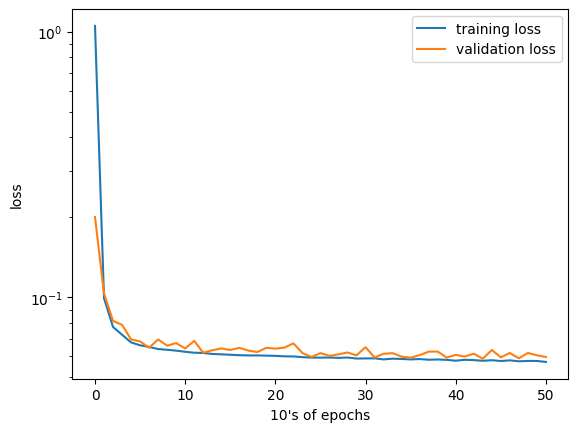

Tot RMSE error: 32.14188


<Figure size 640x480 with 0 Axes>

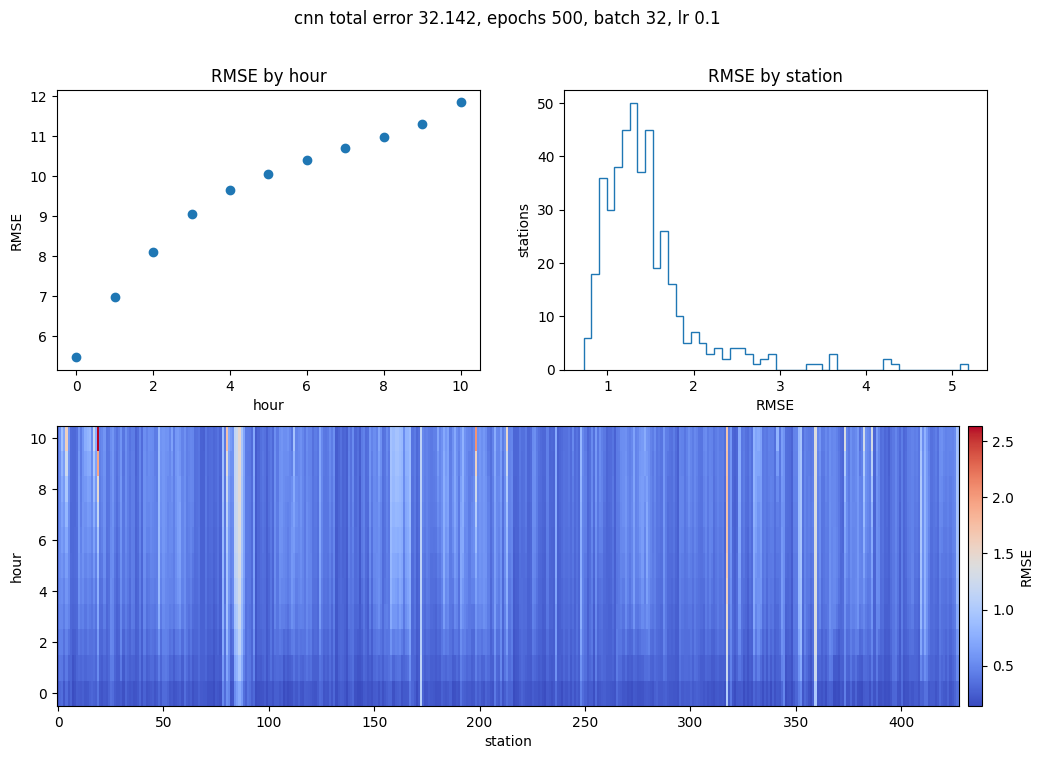

start


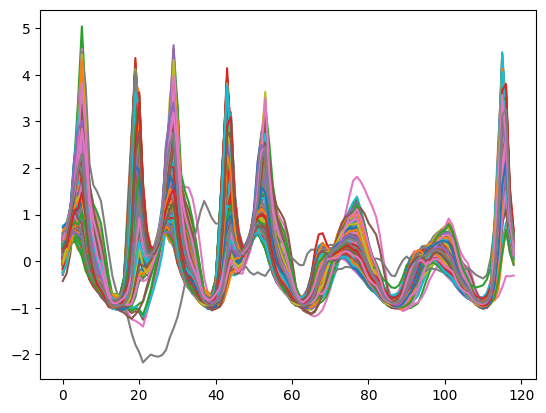

loop
Look in station_plots for the individual station predictions


<Figure size 640x480 with 0 Axes>

In [ ]:
! mkdir -p models
! mkdir -p station_plots
! wget "drive.google.com/uc?export=download&id=1N2HyC5a84gcqrlwQu-y9NYyJYMlxl78M/view?usp=sharing" -O "cnn_e500_lr0.1_b32_encode16_eea9ffa9.pt"
! mv cnn_e500_lr0.1_b32_encode16_eea9ffa9.pt models/cnn_e500_lr0.1_b32_encode16_eea9ffa9.pt

import uuid

forecastLimit = 12 #hours
RMSEs = []
trials = 1
epochs = 500
batch_size=32
learning_rate=.1 #10?
lookback = 12

tag = str(uuid.uuid4()).split('-')[0]


model_cnn_subway,X_test_subway,y_test_subway = TrainCNNOnDataset(selected_subway_data,lookback,batch_size=batch_size,epochs=epochs,learning_rate=learning_rate,tag=tag)
torch.save(model_cnn_subway,"models/cnn_e{}_lr{}_b{}_{}.pt".format(epochs,learning_rate,batch_size,tag))

# load 500 epoch trained model
# model_cnn_subway = torch.load("models/cnn_e500_lr0.1_b32_encode16_eea9ffa9.pt",weights_only=False,map_location=torch.device(device))

tag = "nn_e{}_lr{}_b{}_{}".format(epochs,learning_rate,batch_size,tag)
# computeExtrapolationCNN(model_cnn_subway,X_test_subway,y_test_subway,lookback=12,n_start=0,n_future=5)
forecastMSEs=forecastCNN(model_cnn_subway,X_test_subway,y_test_subway,lookback,forecastLimit)
summaryPlot(forecastMSEs.cpu(),tag)

preds, truth = computeExtrapolationCNN(model_cnn_subway,X_test_subway,y_test_subway,lookback=lookback,n_start=0,n_future=24*5)
stationPlots(preds.cpu(),truth.cpu(),tag)

# Comparison Plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
new_order = [0]*428
for i in range(428):
  for j in range(428):
    if 'station_'+data.iloc[j]['station_complex_id'] == stations[i]:
      new_order[i] = j
      break

reordered_data = data.reindex(new_order)
reordered_data = reordered_data[['station_complex_id','longitude','latitude']].copy()
reordered_data.index = range(len(reordered_data))

unnormalized_preds = preds.cpu().numpy().copy()
unnormalized_truth = truth.cpu().numpy().copy()

for s in range(len(preds)):
  unnormalized_preds[:,s] *= perstation_normalization_mean_and_stds[s][1]
  unnormalized_preds[:,s] += perstation_normalization_mean_and_stds[s][0]

for s in range(len(truth)):
  unnormalized_truth[:,s] *= perstation_normalization_mean_and_stds[s][1]
  unnormalized_truth[:,s] += perstation_normalization_mean_and_stds[s][0]

unnormalized_preds = np.maximum(unnormalized_preds,0)
unnormalized_truth = np.maximum(unnormalized_truth,0)

new_pred_columns = {'Day '+str(d) + ' ' + from_military_time[t] + ' predicted ridership': unnormalized_preds[24*d + t] for d in range(4) for t in range(24)}
new_truth_columns = {'Day '+str(d) + ' ' + from_military_time[t] + ' true ridership': unnormalized_truth[24*d + t] for d in range(4) for t in range(24)}

reordered_data = pd.concat([reordered_data,pd.DataFrame(new_pred_columns)],axis=1)
reordered_data = pd.concat([reordered_data,pd.DataFrame(new_truth_columns)],axis=1)

new_scaled_pred_columns = {'Day '+str(d) + ' ' + from_military_time[t] + ' scaled predicted ridership': 2*np.sqrt(unnormalized_preds[24*d + t]+1) for d in range(4) for t in range(24)}
new_scaled_truth_columns = {'Day '+str(d) + ' ' + from_military_time[t] + ' scaled true ridership': 2*np.sqrt(unnormalized_truth[24*d + t]+1) for d in range(4) for t in range(24)}

reordered_data = pd.concat([reordered_data,pd.DataFrame(new_scaled_pred_columns)],axis=1)
reordered_data = pd.concat([reordered_data,pd.DataFrame(new_scaled_truth_columns)],axis=1)


reordered_data[['station_complex_id','Day 0 12:00:00 AM predicted ridership','Day 0 12:00:00 AM true ridership']].tail(50)

Let's plot the predicted ridership during our four day window.

In [ ]:
#Begin plotting
for d in range(4):
  for t in range(24):
    df_geo_pred = gpd.GeoDataFrame(
      reordered_data, geometry=gpd.points_from_xy(reordered_data.longitude, reordered_data.latitude))
    boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
    axis = boroughs.plot(color = 'lightgray', edgecolor = 'black')
    axis.set_ylim(40.52,40.94)
    axis.set_xlim((-74.1, -73.72))
    bins = [20,40,80,160,320,640,1280, 2560, 5120, 10240, 20480]
    df_geo_pred.plot( 'Day '+str(d) + ' ' + from_military_time[t]+' predicted ridership',
              markersize = 'Day '+str(d) + ' ' + from_military_time[t] + ' scaled predicted ridership',
               scheme = 'userdefined',
               legend = True, k = 10,
               ax = axis, cmap = 'plasma',
               legend_kwds = {'title': 'Ridership',
                              'title_fontsize':25,
                              'loc' : 'center right',
                              'bbox_to_anchor' : (1.36,0.5),
                              'fontsize' : 20,
                              'fancybox' : True,
                              'labels':['0 - 20', '20 - 40', '40 - 80', '80 - 160', '160 - 320', '320 - 640', '640 - 1280', '1280 - 2560', '2560 - 5120', '5120 - 10240', '10240 - 20480']},
               classification_kwds={'bins': bins, 'lowest':0})
    plt.title('Predicted MTA ridership on day ' + str(d) +' at ' + from_military_time[t][:5]+from_military_time[t][-3:], fontsize = 30)

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(13,13)
    plt.savefig(f'/content/drive/Shareddrives/JackNickSharedDrive/predsubwayimages/{d}{t:002}', bbox_inches = 'tight')
    plt.close()

images = []
images_path = '/content/drive/Shareddrives/JackNickSharedDrive/predsubwayimages'

for filename in sorted(os.listdir(images_path)):
  if filename.endswith('.png'):
    images.append(imageio.imread(os.path.join(images_path,filename)))

imageio.mimsave('/content/drive/Shareddrives/JackNickSharedDrive/predictionMTAanimation.gif', images, fps = 3, loop = 0)
Image("/content/drive/Shareddrives/JackNickSharedDrive/predictionMTAanimation.gif")

Next, we plot the true values of the ridership in our four day window.

In [ ]:
#Begin plotting
for d in range(4):
  for t in range(24):
    df_geo_pred = gpd.GeoDataFrame(
      reordered_data, geometry=gpd.points_from_xy(reordered_data.longitude, reordered_data.latitude))
    boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
    axis = boroughs.plot(color = 'lightgray', edgecolor = 'black')
    axis.set_ylim(40.52,40.94)
    axis.set_xlim((-74.1, -73.72))
    bins = [20,40,80,160,320,640,1280, 2560, 5120, 10240, 20480]
    df_geo_pred.plot( 'Day '+str(d) + ' ' + from_military_time[t]+' true ridership',
              markersize = 'Day '+str(d) + ' ' + from_military_time[t] + ' scaled true ridership',
               scheme = 'userdefined',
               legend = True, k = 10,
               ax = axis, cmap = 'plasma',
               legend_kwds = {'title': 'Ridership',
                              'title_fontsize':25,
                              'loc' : 'center right',
                              'bbox_to_anchor' : (1.36,0.5),
                              'fontsize' : 20,
                              'fancybox' : True,
                              'labels':['0 - 20', '20 - 40', '40 - 80', '80 - 160', '160 - 320', '320 - 640', '640 - 1280', '1280 - 2560', '2560 - 5120', '5120 - 10240', '10240 - 20480']},
               classification_kwds={'bins': bins, 'lowest':0})
    plt.title('True MTA ridership on day ' + str(d) +' at ' + from_military_time[t][:5]+from_military_time[t][-3:], fontsize = 30)

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(13,13)
    plt.savefig(f'/content/drive/Shareddrives/JackNickSharedDrive/truesubwayimages/{d}{t:002}', bbox_inches = 'tight')
    plt.close()

images = []
images_path = '/content/drive/Shareddrives/JackNickSharedDrive/truesubwayimages'

for filename in sorted(os.listdir(images_path)):
  if filename.endswith('.png'):
    images.append(imageio.imread(os.path.join(images_path,filename)))

imageio.mimsave('/content/drive/Shareddrives/JackNickSharedDrive/trueMTAanimation.gif', images, fps = 3, loop = 0)
Image("/content/drive/Shareddrives/JackNickSharedDrive/trueMTAanimation.gif")